# Processing diffraction images with *mdx2*

In this tutorial, we will:

- Import diffraction images
- Plot a rocking curve
- Estimate background scattering
- Design an empirical Bragg-peak mask

Requirements:
- `geometry.nxs` from the *mdx2* geometry tutorial
- `refined_1_60.expt` and `background.expt` from the *dials* indexing tutorial

Imports (run this before you do anything else)

In [5]:
# for plotting the rocking curve
from nexusformat.nexus import nxload

## 1) Import diffraction images for *mdx2*

The first step is to copy the image data into a NeXus file. There are two reasons to do this:
1. So that data processing routines don't need to know about detector image formats
2. To take advantage of data compression schemes. The data are "chunked" in 3D so that we can quickly load an image stack around a region of interest. This feature is used below to generate rocking curves.

### *mdx2.import_data*

In [1]:
!mdx2.import_data --help

usage: mdx2.import_data [-h] [--outfile OUTFILE] [--chunks N N N] expt

Import x-ray image data using the dxtbx machinery

positional arguments:
  expt               experiments file, such as from dials.import

optional arguments:
  -h, --help         show this help message and exit
  --outfile OUTFILE  name of the output NeXus file (default: data.nxs)
  --chunks N N N     chunking for compression (frames, y, x) (default: None)


### Parameter choice

We'll choose a "chunk" size of 20-by-211-by-493. Roughly, 211-by-493 corresponds to panel on the Pilatus 6M. And 20 means a stack of 20 frames (2 degrees).  The chunk size is not too important, but it does affect performance, especially memory use.

Operations involving image data are time consuming to run. I suggest doing the tutorial first with the smaller dataset (refined_1_60.expt = first 60 frames).

To re-run with the full image stack, delete all of the *.nxs files except geometry.nxs, and change the line below to:
```
!mdx2.import_data refined.expt --chunks 20 211 493
```
Note that in Jupyter you can re-run an entire notebook by clicking the double-arrow in the task bar (Restart Kernel and Run All Cells)

In [3]:
!mdx2.import_data refined_1_60.expt --chunks 20 211 493

Exporting <class 'mdx2.data.ImageSeries'> to nexus object
  writing image_series to data.nxs
ImageSet: reading frame 0
ImageSet: reading frame 1
ImageSet: reading frame 2
ImageSet: reading frame 3
ImageSet: reading frame 4
ImageSet: reading frame 5
ImageSet: reading frame 6
ImageSet: reading frame 7
ImageSet: reading frame 8
ImageSet: reading frame 9
ImageSet: reading frame 10
ImageSet: reading frame 11
ImageSet: reading frame 12
ImageSet: reading frame 13
ImageSet: reading frame 14
ImageSet: reading frame 15
ImageSet: reading frame 16
ImageSet: reading frame 17
ImageSet: reading frame 18
ImageSet: reading frame 19
ImageSet: reading frame 20
ImageSet: reading frame 21
ImageSet: reading frame 22
ImageSet: reading frame 23
ImageSet: reading frame 24
ImageSet: reading frame 25
ImageSet: reading frame 26
ImageSet: reading frame 27
ImageSet: reading frame 28
ImageSet: reading frame 29
ImageSet: reading frame 30
ImageSet: reading frame 31
ImageSet: reading frame 32
ImageSet: reading frame 33

In [4]:
!mdx2.tree data.nxs

data.nxs: root:NXroot
  @HDF5_Version = '1.10.6'
  @file_name = '/Users/steve/Documents/GitHub/ando-lab/erice-2...'
  @file_time = '2022-05-30T13:39:40.211700'
  @h5py_version = '3.3.0'
  @nexusformat_version = '0.7.5'
  entry:NXentry
    image_series:NXdata
      @axes = ['phi', 'iy', 'ix']
      @mdx2_class = 'ImageSeries'
      @mdx2_module = 'mdx2.data'
      @signal = 'data'
      data = int32(60x2527x2463)
      exposure_times = float64(60)
      ix = float64(2463)
      iy = float64(2527)
      phi = float64(60)


### Visualization in *nexpy*

Open `data.nxs` using *nexpy*.

<div class="alert alert-block alert-info">
    <b>Tip:</b> You might notice that the y-axis is flipped compared with the DIALS image viewer. You can flip it using a check box in the "y" tab.
</div>

## 2) Plot a rocking curve

A rocking curve is a plot of the integrated intensity as a Bragg peak moves in and out of the diffraction condition.

If peaks are close to the spindle axis in reciprocal space, they will move through the Ewald sphere slowly. We can use this to our advantage in order to get a very fine-sliced rocking curve.

I already hunted through the image stack to find such a peak. We can plot it easily using NXdata.project()

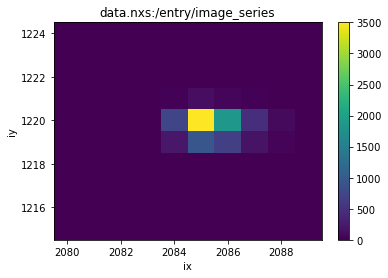

In [7]:
image_series = nxload('data.nxs')['/entry/image_series']

# the peak at its maximum intensity (frame 42)
image_series.project((1,2),limits=((42,42),(1215,1225),(2080,2090))).plot()

We'll plot the rocking curve by summing counts in 2D within the ROI, again using the project() method.

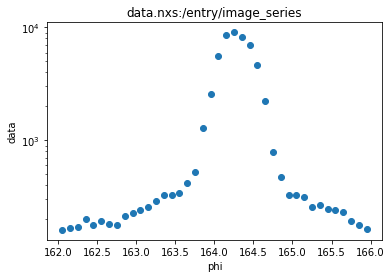

In [9]:
image_series.project(0,limits=((20,60),(1215,1225),(2080,2090))).logplot()

The y-axis is logarithmic in the above plot so that you can see the peak shape clearly.

<div class="alert alert-block alert-info">
    <b>Questions:</b> What do you notice about the peak shape? Does the Bragg peak appear Gaussian? Is it symmetric? Do you see any diffuse scattering?
</div>

## 3) Estimate background scattering

### Import images

First, import the background image stack (50 frames)

In [12]:
!mdx2.import_data background.expt --outfile bkg_data.nxs --chunks 1 211 493

Exporting <class 'mdx2.data.ImageSeries'> to nexus object
  writing image_series to bkg_data.nxs
ImageSet: reading frame 0
ImageSet: reading frame 1
ImageSet: reading frame 2
ImageSet: reading frame 3
ImageSet: reading frame 4
ImageSet: reading frame 5
ImageSet: reading frame 6
ImageSet: reading frame 7
ImageSet: reading frame 8
ImageSet: reading frame 9
ImageSet: reading frame 10
ImageSet: reading frame 11
ImageSet: reading frame 12
ImageSet: reading frame 13
ImageSet: reading frame 14
ImageSet: reading frame 15
ImageSet: reading frame 16
ImageSet: reading frame 17
ImageSet: reading frame 18
ImageSet: reading frame 19
ImageSet: reading frame 20
ImageSet: reading frame 21
ImageSet: reading frame 22
ImageSet: reading frame 23
ImageSet: reading frame 24
ImageSet: reading frame 25
ImageSet: reading frame 26
ImageSet: reading frame 27
ImageSet: reading frame 28
ImageSet: reading frame 29
ImageSet: reading frame 30
ImageSet: reading frame 31
ImageSet: reading frame 32
ImageSet: reading fram

In [13]:
!mdx2.tree bkg_data.nxs

bkg_data.nxs: root:NXroot
  @HDF5_Version = '1.10.6'
  @file_name = '/Users/steve/Documents/GitHub/ando-lab/erice-2...'
  @file_time = '2022-05-30T14:13:04.026536'
  @h5py_version = '3.3.0'
  @nexusformat_version = '0.7.5'
  entry:NXentry
    image_series:NXdata
      @axes = ['phi', 'iy', 'ix']
      @mdx2_class = 'ImageSeries'
      @mdx2_module = 'mdx2.data'
      @signal = 'data'
      data = int32(50x2527x2463)
      exposure_times = float64(50)
      ix = float64(2463)
      iy = float64(2527)
      phi = float64(50)


#### Visualization in *nexpy*
Open `bkg_data.nxs` using *nexpy*. 

<div class="alert alert-block alert-info">
    <b>Questions:</b> What features do you see? Does the background change as a function of phi?
</div>

### Downsampling

Since the background scattering pattern is relatively smooth, we can improve the signal to noise by re-binning the image stack in both x-y direction and phi direction.

#### *mdx2.bin_image_series*

In [15]:
!mdx2.bin_image_series --help

usage: mdx2.bin_image_series [-h] [--outfile OUTFILE] [--valid_range N N]
                             data N N N

Bin down an image stack

positional arguments:
  data               NeXus data file containing the image_series
  N                  number per bin in each direction (frames, y, x)

optional arguments:
  -h, --help         show this help message and exit
  --outfile OUTFILE  name of the output NeXus file (default: binned.nxs)
  --valid_range N N  minimum and maximum valid data values (default: None)


#### Choosing parameters

We'll choose to bin (average) every 10 frames and 20-by-20 block of pixels.

In addition, we'll reject any pixels with more than 200 counts. The nominal count rate is around 20 counts per pixel. The threshold at 200 will mostly reject broken pixels and stray diffraction (e.g. from tiny salt crystals).

In [20]:
!mdx2.bin_image_series bkg_data.nxs 10 20 20 --valid_range 0 200 --outfile bkg_data_binned.nxs

Reading image_series from bkg_data.nxs
  importing as ImageSeries from mdx2.data
binning frames 0 to 9
binning frames 10 to 19
binning frames 20 to 29
binning frames 30 to 39
binning frames 40 to 49
saving to file: bkg_data_binned.nxs
Exporting <class 'mdx2.geometry.GridData'> to nexus object
  writing binned_image_series to bkg_data_binned.nxs


In [21]:
!mdx2.tree bkg_data_binned.nxs

bkg_data_binned.nxs: root:NXroot
  @HDF5_Version = '1.10.6'
  @file_name = '/Users/steve/Documents/GitHub/ando-lab/erice-2...'
  @file_time = '2022-05-30T14:58:21.978633'
  @h5py_version = '3.3.0'
  @nexusformat_version = '0.7.5'
  entry:NXentry
    binned_image_series:NXdata
      @axes = ['phi', 'iy', 'ix']
      @mdx2_class = 'GridData'
      @mdx2_module = 'mdx2.geometry'
      @signal = 'signal'
      ix = float64(124)
      iy = float64(127)
      phi = float64(5)
      signal = float64(5x127x124)


#### Visualization in *nexpy*
Open `bkg_data_binned.nxs` in *nexpy*.

<div class="alert alert-block alert-info">
    <b>Questions:</b> What new features can you see now that the signal to noise is improved?  Does the background change with spindle angle?
</div>

We'll use the downsampled background map in a later tutorial.

## 4) Masking Bragg peaks

### Background

To map diffuse scattering we need to mask out the Bragg peaks. Designing a the perfect mask is a tricky problem, and different research have approached it multiple ways. 

As we saw previously with the rocking curve example, a Bragg peaks' extent in phi can vary depending on the distance from the spindle angle. And, Bragg peaks may not be perfectly symmetric Gaussian peaks. Peak width depends on crystal mosaicity, and this can even vary during a scan. In addition, the diffraction geometry may not be modeled exactly right, leading to further errors in peak position. A masking function must account for all of these effects.

With *mdx2* we take a simple empirical approach. Here is the algorithm:

1. List all of the pixels in the image stack above a certain count threshold ("hot pixels"). 
2. Index all of the hot pixels, converting their position in image space to (fractional) Miller index (h,k,l). 
3. Subtract the nearest integer from h,k,l leaving only the fractional part (dh, dk, dl) which varies from -0.5 to 0.5. Because peaks have finite extent, the values of dh,dk,dl will not all be zero, but will look like a cloud of points. 
4. Fit an anisotropic 3D Gaussian distribution to the cloud of points. Flag outliers beyond a certain sigma threshold ("bad pixels")
5. Create a mask for **all** pixels in the image stack excluding outliers and pixels falling within the 3D Gaussian region according to a sigma threshold.

### Hot pixels 

#### *mdx2.find_peaks*

In [23]:
!mdx2.find_peaks --help

usage: mdx2.find_peaks [-h] --count_threshold THRESH [--sigma_cutoff SIGMA]
                       [--outfile OUTFILE]
                       geom data

Find and analyze peaks in an image stack

positional arguments:
  geom                  NeXus file w/ miller_index
  data                  NeXus file w/ image_series

optional arguments:
  -h, --help            show this help message and exit
  --count_threshold THRESH
                        pixels with counts above threshold are flagged as
                        peaks (default: None)
  --sigma_cutoff SIGMA  or outlier rejection in Gaussian peak fitting
                        (default: 3)
  --outfile OUTFILE     name of the output NeXus file (default: peaks.nxs)


#### Parameters

We need to choose a count threshold for "hot" pixels. In the fine-sliced images (0.1 second exposure) the background level is around 2 photons per pixel. So we'll choose a threshold of 20 (10x the background).

The default value for sigma_cutoff works well here.

In [25]:
!mdx2.find_peaks geometry.nxs data.nxs --count_threshold 20

Reading miller_index from geometry.nxs
  importing as MillerIndex from mdx2.geometry
Reading image_series from data.nxs
  importing as ImageSeries from mdx2.data
finding pixels with counts above threshold: 20.0
found 8 peaks in chunk 1
found 22 peaks in chunk 2
found 31 peaks in chunk 3
found 67 peaks in chunk 6
found 246 peaks in chunk 7
found 80 peaks in chunk 8
found 5 peaks in chunk 9
found 4 peaks in chunk 10
found 272 peaks in chunk 11
found 683 peaks in chunk 12
found 340 peaks in chunk 13
found 19 peaks in chunk 14
found 48 peaks in chunk 15
found 474 peaks in chunk 16
found 938 peaks in chunk 17
found 638 peaks in chunk 18
found 75 peaks in chunk 19
found 77 peaks in chunk 20
found 599 peaks in chunk 21
found 967 peaks in chunk 22
found 783 peaks in chunk 23
found 123 peaks in chunk 24
found 124 peaks in chunk 25
found 434 peaks in chunk 26
found 411 peaks in chunk 27
found 632 peaks in chunk 28
found 123 peaks in chunk 29
found 90 peaks in chunk 30
found 440 peaks in chunk 31

#### Peak model

The output from *mdx2.find_peaks* above includes the $\mathbf{r_0}$ and $\sigma$ values for the anisotropic Gaussian function that fit the $\mathbf{r}=(\Delta h,\Delta k,\Delta l)$ point cloud.

Specifically, the Gaussian function is:

$p(\mathbf{r}) \propto \exp\left[ -\tfrac{1}{2} \left| \mathbf{\sigma}^{-1} (\mathbf{r} - \mathbf{r_0}) \right|^2 \right] $

Find `sigma` and `r0` in the output above.
- How anisotropic is the point cloud? (is the `sigma` matrix diagonal?)
- What value of $\Delta l$ represents a probability of one sigma?

### Creating the mask

The final step is to generate a mask for every pixel.

#### *mdx2.mask_peaks*

In [28]:
!mdx2.mask_peaks --help

usage: mdx2.mask_peaks [-h] [--sigma_cutoff SIGMA] [--outfile OUTFILE]
                       geom data peaks

Create a peak mask for in an image stack

positional arguments:
  geom                  NeXus file w/ miller_index
  data                  NeXus file w/ image_series
  peaks                 NeXus file w/ peak_model and peaks

optional arguments:
  -h, --help            show this help message and exit
  --sigma_cutoff SIGMA  \sigma value to draw the peak mask (default: 3)
  --outfile OUTFILE     name of the output NeXus file (default: mask.nxs)


#### Parameters

The only parameter we need to choose is the `sigma_cutoff`. The default value of 3 works well in this case.

Note that our masking approach is robust but kind of slow, because it is necessary to compute Miller indices for all of the pixels in the image stack. Be patient.

In [29]:
!mdx2.mask_peaks geometry.nxs data.nxs peaks.nxs --sigma_cutoff 3

Reading miller_index from geometry.nxs
  importing as MillerIndex from mdx2.geometry
Reading image_series from data.nxs
  importing as ImageSeries from mdx2.data
Reading peak_model from peaks.nxs
  importing as GaussianPeak from mdx2.geometry
Reading peaks from peaks.nxs
  importing as Peaks from mdx2.data
masking peaks with sigma above threshold: 3.0
indexing chunk 0
indexing chunk 1
indexing chunk 2
indexing chunk 3
indexing chunk 4
indexing chunk 5
indexing chunk 6
indexing chunk 7
indexing chunk 8
indexing chunk 9
indexing chunk 10
indexing chunk 11
indexing chunk 12
indexing chunk 13
indexing chunk 14
indexing chunk 15
indexing chunk 16
indexing chunk 17
indexing chunk 18
indexing chunk 19
indexing chunk 20
indexing chunk 21
indexing chunk 22
indexing chunk 23
indexing chunk 24
indexing chunk 25
indexing chunk 26
indexing chunk 27
indexing chunk 28
indexing chunk 29
indexing chunk 30
indexing chunk 31
indexing chunk 32
indexing chunk 33
indexing chunk 34
indexing chunk 35
indexing

#### Visualization in *nexpy*

In *nexpy* open `mask.nxs`, and double-click the object in the tree to plot it.

<div class="alert alert-block alert-info">
    <b>Question 1:</b> Zoom on on some Bragg peaks. How does the mask shape look in different regions of the detector?
</div>

<div class="alert alert-block alert-info">
    <b>Question 2:</b> Scroll through the image stack by changing the z-slice (phi). Compare peaks near the spindle axis with peaks far away. Does the mask account for the different rates that peaks move through the Ewald sphere?
</div>

Note: The current version of *mdx2* does not account for systematic absences. This is a particular issue with cubic insulin, because for space group $\textrm{I}2_13$ the reflection condition is $h + k + l = 2n$. So we're masking about twice as many spots as necessary. But our Bragg peak mask is pretty tight, so we're not losing a lot of pixels.